# TP1 - Compressão e Descompressão de Imagem

**Alunos:** Vinicius Silva Gomes - 2021421869
            (bota seu nome aqui joão) - 9999999999

In [2]:
# Importação das bibliotecas

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
# Variáveis e funções auxiliares

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def compression_rate(original_image, compressed_image):
    original_image_size = os.stat('source.jpg').st_size
    compressed_image_size = os.stat('compressed.jpg').st_size
    
    return original_image_size/compressed_image_size

quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])

Dimensões da imagem: 1080x1080
Tamanho da imagem (em disco): 0.1514 MB / 151.4 kB


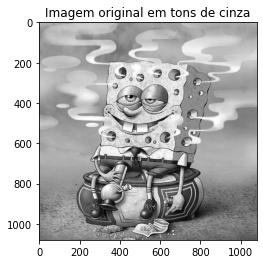

In [12]:
# Importação da imagem sem compressão e informações relevantes sobre ela

source_image = cv2.imread('source.jpg', 0)
source_image_size = os.stat('source.jpg').st_size

print("Dimensões da imagem: {}x{}".format(source_image.shape[1], source_image.shape[0]))
print("Tamanho da imagem (em disco): {} MB / {} kB".format(source_image_size/10 ** 6, source_image_size/10 ** 3))

plt.title("Imagem original em tons de cinza")
plt.imshow(source_image, cmap="gray")

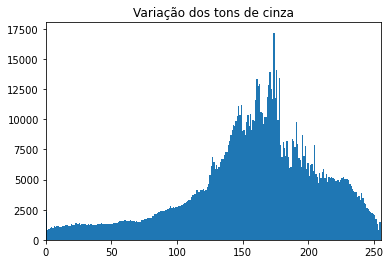

In [13]:
# Histograma com os níveis de cinza da imagem

flattered_img = source_image.ravel()

plt.hist(flattered_img, 256, [0,255]);
plt.xlim([0, 255])
plt.title("Variação dos tons de cinza")
plt.show()

In [18]:
# Método de compressão

In [16]:
# Método de descompressão

In [17]:
# Considerações e métricas sobre o processo de compressão/descompressão

# rmse_calc = rmse(source_image, idct)
# psnr_calc = psnr()
compression_rate_calc = compression_rate(source_image, source_image)

# print("Erro médio quadrático: {}".format(rmse_calc))
# print("PSNR: {}".format(psnr_calc))
print("Taxa de compressão: {}".format(round(compression_rate_calc, 4)))

Taxa de compressão: 0.5703
